In [1]:
#Utility imports
import re
import os
import logging
import time
import pickle
import itertools
from collections import Counter

In [2]:
# ML basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# keras imports 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [5]:
# nltk imports
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [6]:
# import Word2Vec
import gensim

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kushagra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 128

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [9]:
df = pd.read_csv("train_set.csv",encoding = DATASET_ENCODING,names=DATASET_COLUMNS)

In [10]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [11]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


<b>The value description for "target" column : </b>
<ul>
    <li> 0 -> Negative</li>
    <li> 2 -> Neutral</li>
    <li> 4 -> Positive</li>
</ul>

In [12]:
map_decode = {0:"NEGATIVE",2:"NEUTRAL",4:"POSITIVE"}  #Dictionary for "target" decoding

def decode_sentiment(label):
    return map_decode[int(label)]

In [13]:
# decoding the "target" column of the dataset
df.target = df.target.apply(lambda x: decode_sentiment(x))

In [14]:
df.head(5)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [15]:
df.tail(5)

,target,ids,date,flag,user,text
1599995,POSITIVE,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,POSITIVE,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,POSITIVE,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,POSITIVE,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,POSITIVE,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


Text(0.5, 1.0, 'Number of labels')

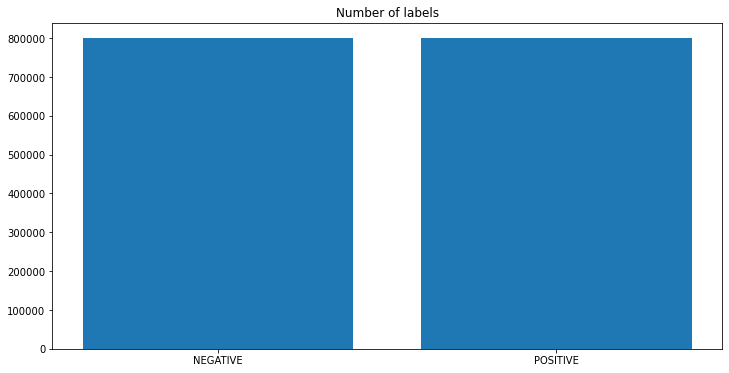

In [16]:
target_cnt = Counter(df.target)
plt.figure(figsize=(12,6))
plt.bar(target_cnt.keys(),target_cnt.values())
plt.title('Number of labels')

In [17]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [18]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [19]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 47.5 s


In [20]:
df_train, df_test = train_test_split(df,test_size=1-TRAIN_SIZE,random_state = 42)

In [21]:
print("Train_set size:",len(df_train))
print("Test_set size:",len(df_test))

Train_set size: 1280000
Test_set size: 320000


In [22]:
df_train.head(5)

,target,ids,date,flag,user,text
1374558,POSITIVE,2051457557,Fri Jun 05 22:04:23 PDT 2009,NO_QUERY,JGoldsborough,ya quot like palm pre touchstone charger ready...
1389115,POSITIVE,2053083567,Sat Jun 06 03:12:21 PDT 2009,NO_QUERY,Psioui,felt earthquake afternoon seems epicenter
1137831,POSITIVE,1976779404,Sat May 30 19:02:49 PDT 2009,NO_QUERY,adriville,ruffles shirts like likey
790714,NEGATIVE,2325739990,Thu Jun 25 05:59:18 PDT 2009,NO_QUERY,Blondie128,pretty bad night crappy morning fml buttface d...
1117911,POSITIVE,1973503391,Sat May 30 11:16:35 PDT 2009,NO_QUERY,khrabrov,yeah clear view


In [24]:
documents = [ _text.split() for _text in df_train.text]

w2v_model  = gensim.models.word2vec.Word2Vec(size = W2V_SIZE,
                                            window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers = 8)

In [25]:
w2v_model.build_vocab(documents)

In [26]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print('Vocab size',vocab_size)

Vocab size 30369


In [27]:
w2v_model.train(documents,total_examples=len(documents),epochs=W2V_EPOCH)

(263122373, 295270528)

In [28]:
w2v_model.most_similar("love")

C:\Users\Kushagra\anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('loves', 0.5734601020812988),
 ('luv', 0.5694621801376343),
 ('loved', 0.549036979675293),
 ('looove', 0.5040318965911865),
 ('adore', 0.5038667917251587),
 ('amazing', 0.499722957611084),
 ('awesome', 0.4642348289489746),
 ('loveee', 0.46140921115875244),
 ('lovee', 0.44999030232429504),
 ('loooove', 0.43240469694137573)]

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

In [30]:
vocab_size = len(tokenizer.word_index) + 1
print("Total words",vocab_size)

Total words 290419


In [31]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text),maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text),maxlen=SEQUENCE_LENGTH)


In [32]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [33]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print('y_test',y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [34]:
print("x_train",x_train.shape)
print("y_train",y_train.shape)
print("---------------------")
print("x_test",x_test.shape)
print("y_test",y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)
---------------------
x_test (320000, 300)
y_test (320000, 1)


In [35]:
y_train[:7]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1]], dtype=int64)

In [36]:
embedding_matrix = np.zeros((vocab_size,W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [37]:
embedding_layer = Embedding(vocab_size,W2V_SIZE,weights=[embedding_matrix],input_length=SEQUENCE_LENGTH,trainable=False)

In [38]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.25))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [39]:
model.compile(loss='binary_crossentropy',
             optimizer = 'adam',
             metrics=['accuracy'])

In [40]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]


In [49]:
history = model.fit(x_train,y_train,
                   batch_size = BATCH_SIZE,
                   epochs=1,
                   validation_split=0.1,
                   verbose=1,
                   callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
1152000/1152000 [==============================] - 9850s 9ms/sample - loss: 0.4738 - accuracy: 0.7712 - val_loss: 0.4496 - val_accuracy: 0.7880


In [51]:
score = model.evaluate(x_test,y_test,batch_size=BATCH_SIZE)
print()
print('ACCURACY:',score[1])
print('LOSS:',score[0])

320000/320000 [==============================] - 775s 2ms/sample - loss: 0.4483 - accuracy: 0.7878

ACCURACY: 0.7877531
LOSS: 0.4482789170742035


In [52]:
def get_sentiment(score,include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score > SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE
        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [60]:
def predict(text,include_neutral=True):
    start_at = time.time()
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]),
                           maxlen=SEQUENCE_LENGTH)
    score = model.predict([x_test])[0]
    label = get_sentiment(score, include_neutral=include_neutral)
    return {'label':label,"score:float":(score),
           "elapsed_time":time.time() - start_at}

In [61]:
predict("I love the dog")

{'label': 'POSITIVE',
 'score:float': array([0.91937953], dtype=float32),
 'elapsed_time': 0.25098228454589844}

In [57]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

In [62]:
predict("I hate mangos")

{'label': 'NEGATIVE',
 'score:float': array([0.03775638], dtype=float32),
 'elapsed_time': 0.4588737487792969}

In [64]:
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test,verbose=1,batch_size=512)
y_pred_1d = [get_sentiment(score,include_neutral=False) for score in scores]

320000/320000 [==============================] - 431s 1ms/sample


In [75]:
def plot_confusion_matrix(cm,classes,title='Confusion matrix'
                          ,cmap=plt.cm.Greens):
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title,fontsize=25)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

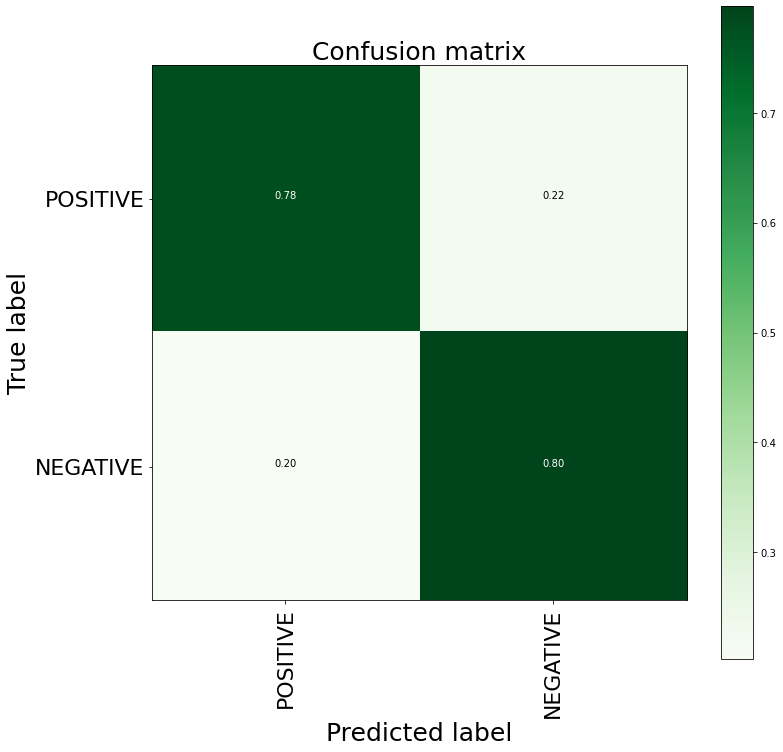

Wall time: 1.05 s


In [76]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [77]:
print(classification_report(y_test_1d,y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.78      0.79    159494
    POSITIVE       0.78      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [79]:
accuracy_score(y_test_1d,y_pred_1d)

0.787753125

In [80]:
predict("How are you?")

{'label': 'NEUTRAL',
 'score:float': array([0.5749061], dtype=float32),
 'elapsed_time': 0.3827509880065918}

In [81]:
predict("Where are you going?")

{'label': 'NEUTRAL',
 'score:float': array([0.47604722], dtype=float32),
 'elapsed_time': 0.2667274475097656}

In [83]:
predict("I dont like cats")

{'label': 'NEGATIVE',
 'score:float': array([0.27539933], dtype=float32),
 'elapsed_time': 1.1960387229919434}

In [84]:
predict("I like chicken curry")

{'label': 'POSITIVE',
 'score:float': array([0.77035797], dtype=float32),
 'elapsed_time': 0.3744349479675293}

In [85]:
predict("He is a stupid guy.")

{'label': 'NEGATIVE',
 'score:float': array([0.17447323], dtype=float32),
 'elapsed_time': 0.23453330993652344}

In [87]:
predict("Hello there")

{'label': 'POSITIVE',
 'score:float': array([0.9805054], dtype=float32),
 'elapsed_time': 3.744785785675049}

In [91]:
predict("I have an amazing apple")

{'label': 'POSITIVE',
 'score:float': array([0.92892426], dtype=float32),
 'elapsed_time': 0.9497506618499756}

In [93]:
predict("I do have a mango")

{'label': 'POSITIVE',
 'score:float': array([0.8195035], dtype=float32),
 'elapsed_time': 2.081984043121338}

In [94]:
predict("I dont like this program")

{'label': 'NEGATIVE',
 'score:float': array([0.2772094], dtype=float32),
 'elapsed_time': 1.824580192565918}

In [95]:
predict("what a gllant man")

{'label': 'NEUTRAL',
 'score:float': array([0.5955925], dtype=float32),
 'elapsed_time': 1.0167255401611328}

In [96]:
predict("He is shevelrous")

{'label': 'NEUTRAL',
 'score:float': array([0.5749061], dtype=float32),
 'elapsed_time': 0.5432803630828857}

In [97]:
predict("This book isnt that bad")

{'label': 'NEGATIVE',
 'score:float': array([0.11664126], dtype=float32),
 'elapsed_time': 0.4165160655975342}

In [98]:
predict("This is pretty good book")

{'label': 'POSITIVE',
 'score:float': array([0.97210175], dtype=float32),
 'elapsed_time': 0.49065470695495605}

In [99]:
predict("She is not as pretty as her pictures")

{'label': 'POSITIVE',
 'score:float': array([0.9213239], dtype=float32),
 'elapsed_time': 0.3282957077026367}

In [100]:
predict("She is not that pretty")

{'label': 'POSITIVE',
 'score:float': array([0.8789277], dtype=float32),
 'elapsed_time': 0.2792174816131592}

In [101]:
predict("I live in combolia")

{'label': 'NEUTRAL',
 'score:float': array([0.5479298], dtype=float32),
 'elapsed_time': 0.681196928024292}

<b> Code to use the pre-trained model </b>

In [2]:
from tensorflow.keras.models import load_model
import time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
import pickle

In [7]:

w2v_model = Word2Vec.load("model.w2v")
model = load_model('model.h5')
with open('tokenizer.pkl','rb') as handle:
    tokenizer = pickle.load(handle)
with open('encoder.pkl','rb') as handle:
    encoder = pickle.load(handle)

In [14]:
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 512
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = 'NEUTRAL'
SENTIMENT_THRESHOLDS = (0.4,0.7)

In [15]:
def get_sentiment(score,include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score > SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE
        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE
    
    
def predict(text,include_neutral=True):
    start_at = time.time()
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]),
                           maxlen=SEQUENCE_LENGTH)
    score = model.predict([x_test])[0]
    label = get_sentiment(score, include_neutral=include_neutral)
    return {'label':label,"score:float":(score),
           "elapsed_time":time.time() - start_at}

In [17]:
predict("importance of time speech by smile please world Good morning respected principal teachers parents and my dear friends today I am here to share my way was about importance of time it is rightly said that time and tide waits for none be it rich or poor time waits for no one we all are allotted a certain amount of time in our lives and hence we must use it wisely time once past can be brought back time is precious and we must not waste it if we utilise our time properly it will help us to have a bright future where as if we keep on wasting time by doing meaning Mein staff it can lead to failure time is more precious than money every person who wants to be successful bus understand the value of time we must plan all over activities to save time students can make a timetable to revise their syllabus so that it becomes easy to study during exams grown-ups also need to save time and utilise it for productive work doing the right things at right time is also important striking a cold iron cannot be useful the right time is when the iron is Red Hot hence we say A stitch in time saves nine when we save time we can utilise it to focus on our help and learning new things spending our time with our family is also equally important it is said that time is the most precious gift you can give someone then why not give it to our loved ones when we give someone our time we give them a portion of our life that we will never get back when we spend our time with our family what we get in return is memorable moments of life it is said that time is money but we must know that if we lose money we can get it back somehow but if we lose time it cannot be recovered by any way if we look at the successful people in the world we can see that they all value that time they know that time is an important resource but it is limited and not renewable hence we should never waste our time and make the best out of it with this I and my speech thank you thanks for watching")

{'label': 'POSITIVE',
 'score:float': array([0.8148421], dtype=float32),
 'elapsed_time': 0.21154069900512695}